# CNN - Etiquetado de mariposas


In [146]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [147]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers

In [148]:
df = pd.read_csv("../CNN/resources/Training_set.csv")
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


---

---

In [149]:
from sklearn.model_selection import train_test_split

########################################
# 1. SEPARAR EN ENTRENAMIENTO Y VALIDACIÓN
########################################
train_df, val_df = train_test_split(
    df, 
    test_size=0.2,       # 20% validación, 80% entrenamiento
    random_state=42,     # Para reproducir la partición si lo deseas
    stratify=df['label'] # (Opcional) para balancear las clases
)

# Revisar cuántos datos quedaron en cada subconjunto
print(f"Entrenamiento: {len(train_df)} imágenes")
print(f"Validación: {len(val_df)} imágenes")

Entrenamiento: 5199 imágenes
Validación: 1300 imágenes


In [150]:
########################################
# 2. DEFINIR DATAGENERATORS
########################################

# GENERADOR DE ENTRENAMIENTO (con augmentations)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2)
)

# GENERADOR DE VALIDACIÓN (solo reescala)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [151]:
########################################
# 3. CREAR LOS GENERADORES DESDE LOS DATAFRAMES
########################################

# Parámetros comunes
batch_size = 16
img_size = (224, 224)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                   # DataFrame de entrenamiento
    directory="../CNN/resources/train",   # Carpeta con las imágenes
    x_col='filename',                     # Nombre de archivo
    y_col='label',                        # Etiqueta
    class_mode='categorical',             # One-hot encoding para clasificación multiclase
    target_size=img_size,                 # Redimensiona a 224x224
    batch_size=batch_size,
    shuffle=True,                         # Baraja datos en cada epoch
    color_mode='rgb'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                     # DataFrame de validación
    directory="../CNN/resources/train",
    x_col='filename',
    y_col='label',
    class_mode='categorical',
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,                        # Normalmente no barajamos validación
    color_mode='rgb'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


---

In [152]:
# Número de clases 
num_clases = len(train_generator.class_indices)
num_clases


75

In [153]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),

    # Bloque 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.2),

    # Bloque 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    # Bloque 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.4),

    # Bloque 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.4),

    # Global pooling
    tf.keras.layers.GlobalAveragePooling2D(),

    # Capa densa
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Capa de salida
    tf.keras.layers.Dense(num_clases, activation='softmax')
])
    
# Flatten para conectar con las capas densas
# tf.keras.layers.Flatten(),

In [154]:
# Mostrar resumen de la arquitectura
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,261,163 (4.81 MB)

 Trainable params: 1,259,243 (4.80 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [155]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [156]:
# Entrenamos el modelo
early_stop = EarlyStopping(
    monitor='val_loss',  # o 'val_accuracy'
    patience=3,          # número de épocas que espera sin mejora
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100


/home/pablost/Bootcamp_DataScience_IA/.env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


325/325 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.0401 - loss: 5.0339 - val_accuracy: 0.0138 - val_loss: 6.4952 - learning_rate: 0.0010
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.1000 - loss: 4.0503 - val_accuracy: 0.1423 - val_loss: 3.6446 - learning_rate: 0.0010
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.1466 - loss: 3.6466 - val_accuracy: 0.1331 - val_loss: 4.0092 - learning_rate: 0.0010
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 28s 86ms/step - accuracy: 0.1633 - loss: 3.4396 - val_accuracy: 0.1908 - val_loss: 3.3602 - learning_rate: 0.0010
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 28s 86ms/step - accuracy: 0.2194 - loss: 3.1891 - val_accuracy: 0.2346 - val_loss: 3.1645 - learning_rate: 0.0010
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 29s 88ms/step - accuracy: 0.2592 - loss: 3.0070 - val_accuracy: 0.2138 - val_loss: 3.5855 - learning_rate: 0.0010
Epoch 7/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - accuracy: 0.2632 - loss:

0.82

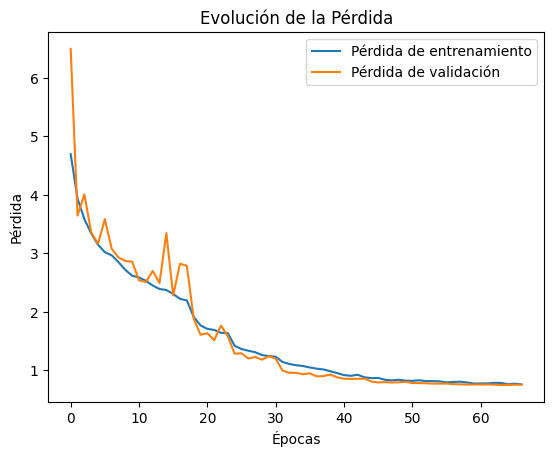

In [157]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


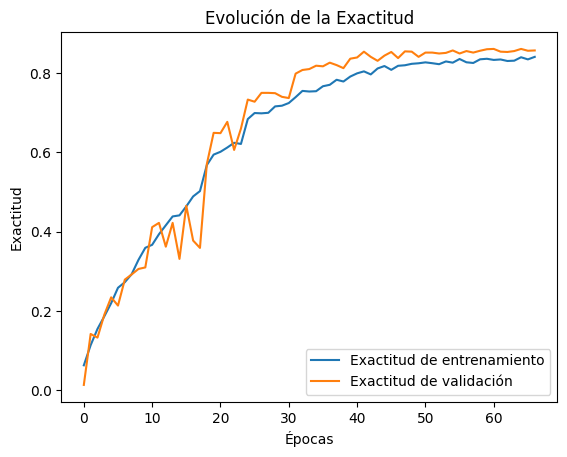

In [158]:
plt.plot(history.history['accuracy'], label='Exactitud de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Exactitud de validación')
plt.title('Evolución de la Exactitud')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

In [159]:
# Predecir sobre el set de validación
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
                           precision    recall  f1-score   support

                   ADONIS       0.89      0.94      0.92        18
AFRICAN GIANT SWALLOWTAIL       0.85      0.73      0.79        15
           AMERICAN SNOOT       1.00      0.73      0.85        15
                    AN 88       1.00      0.94      0.97        17
                  APPOLLO       0.94      0.89      0.91        18
                    ATALA       0.95      1.00      0.98        20
 BANDED ORANGE HELICONIAN       1.00      0.95      0.97        20
           BANDED PEACOCK       0.76      0.94      0.84        17
            BECKERS WHITE       0.65      0.81      0.72        16
         BLACK HAIRSTREAK       0.93      0.76      0.84        17
              BLUE MORPHO       0.92      0.73      0.81        15
        BLUE SPOTTED CROW       0.80      0.71      0.75        17
           BROWN SIPROETA       0.89      0.85      0.87        20
            CABBAGE W